Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>2000) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [5]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5406043307626863

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [6]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_6_h','Strt_ERA_6_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v', 
]
target = 'home_victory'

In [7]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 8), (10615, 8), (7285, 8))

In [9]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.690091
[20]	valid_0's binary_logloss: 0.689431
[30]	valid_0's binary_logloss: 0.688683
[40]	valid_0's binary_logloss: 0.688141
[50]	valid_0's binary_logloss: 0.687602
[60]	valid_0's binary_logloss: 0.687069
[70]	valid_0's binary_logloss: 0.686663
[80]	valid_0's binary_logloss: 0.68624
[90]	valid_0's binary_logloss: 0.685856
[100]	valid_0's binary_logloss: 0.685531
[110]	valid_0's binary_logloss: 0.685248
[120]	valid_0's binary_logloss: 0.685037
[130]	valid_0's binary_logloss: 0.684815
[140]	valid_0's binary_logloss: 0.684536
[150]	valid_0's binary_logloss: 0.684313
[160]	valid_0's binary_logloss: 0.684096
[170]	valid_0's binary_logloss: 0.683888
[180]	valid_0's binary_logloss: 0.683749
[190]	valid_0's binary_logloss: 0.683594
[200]	valid_0's binary_logloss: 0.68341
[210]	valid_0's binary_logloss: 0.683293
[220]	valid_0's binary_logloss: 0.683153
[230]	valid_0's binary_logloss: 0.683013
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [10]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [11]:
# previous model gave 0.6853993814658048
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6832422202913799, 0.6913722730242492)

In [12]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6704071693200951

It would behoove us to be define a way to quantify to relate our models both to the Las Vegas oddsmakers model and if we were to "naively" select the home team 53.8% of the time because that's what seems to happen.

As a reminder, our models include:

    - Simple (first): OBP & SLG
    - Current: OBP, SLG, + Starting Pitcher ERA and WHIP over their past 14 starts

We will define a 'basis point' (bp) to be log_loss = 0.0001

This will allow us to relate the models to each other and using more familiar integer values

In [13]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([0.6905 - 0.6676, 0.6905 - 0.6854, 0.6905 - 0.6704], decimals=4)

array([0.0229, 0.0051, 0.0201])

In [14]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

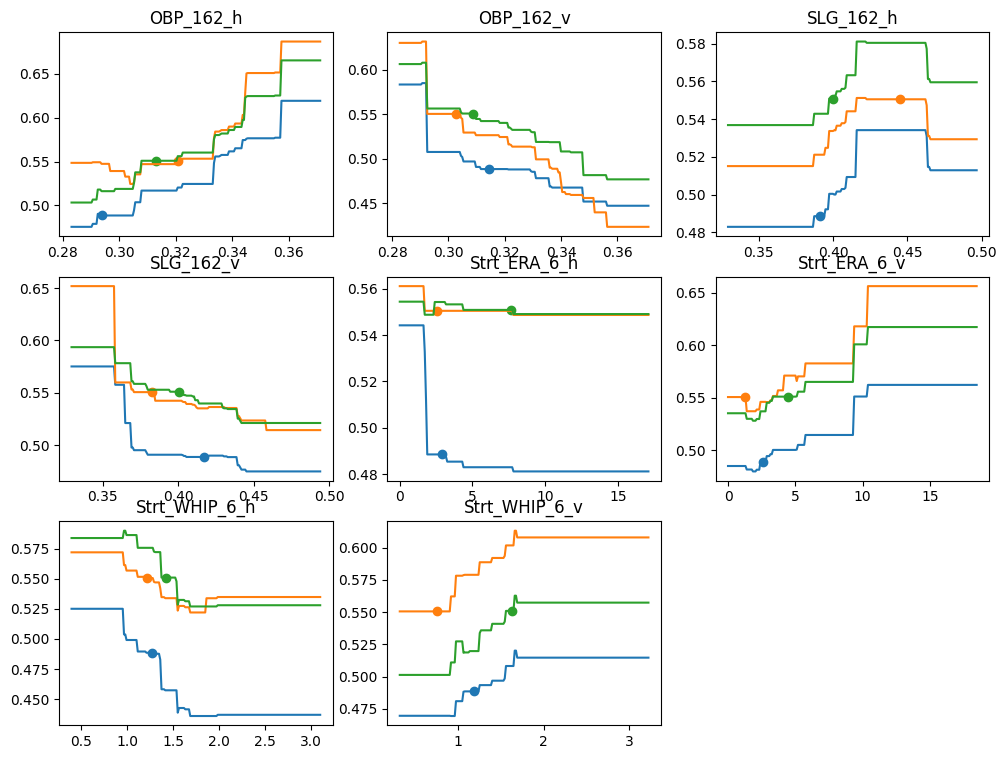

In [15]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

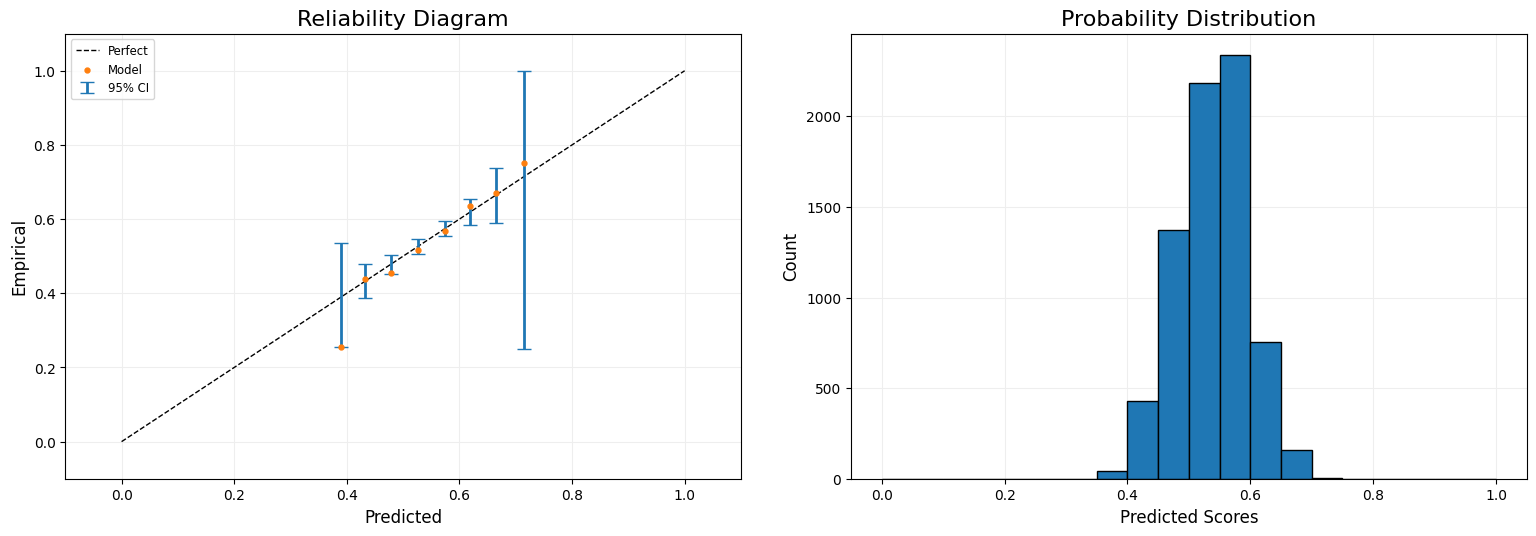

In [16]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [17]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [18]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_6_h,Strt_ERA_6_v,Strt_WHIP_6_h,Strt_WHIP_6_v,Intercept
0,-0.036,0.074,0.054,0.022,-0.004,0.022,0.094,0.047,0.165
1,-0.040,0.060,0.054,0.031,-0.005,0.058,0.065,0.011,0.165
2,-0.051,-0.004,0.051,-0.082,-0.000,-0.072,0.066,-0.189,0.165
3,-0.120,0.027,-0.104,-0.008,-0.006,-0.020,0.066,-0.119,0.165
4,-0.044,0.002,0.047,-0.045,-0.005,-0.020,0.203,-0.182,0.165


In [19]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept        0.164538
Strt_WHIP_6_h    0.080680
OBP_162_h        0.072832
OBP_162_v        0.069956
SLG_162_h        0.058909
Strt_WHIP_6_v    0.047994
SLG_162_v        0.037886
Strt_ERA_6_v     0.028764
Strt_ERA_6_h     0.009467
dtype: float64

Let's add in a few more pitching features...

In [26]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_6_h','Strt_ERA_6_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
            'Strt_H_BB_perc_6_h', 'Strt_H_BB_perc_6_v',
           # 'Strt_ERA_34_h','Strt_ERA_34_v',
           # 'Strt_WHIP_34_h','Strt_WHIP_34_v',
           # 'Strt_SO_perc_34_h', 'Strt_SO_perc_34_v',
           # 'Strt_TB_BB_perc_34_h', 'Strt_TB_BB_perc_34_v',
           # 'Strt_H_BB_perc_34_h', 'Strt_H_BB_perc_34_v',
]
target = 'home_victory'

In [27]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [28]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 14), (10615, 14), (7285, 14))

In [29]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689886
[20]	valid_0's binary_logloss: 0.689157
[30]	valid_0's binary_logloss: 0.688521
[40]	valid_0's binary_logloss: 0.68787
[50]	valid_0's binary_logloss: 0.68725
[60]	valid_0's binary_logloss: 0.686732
[70]	valid_0's binary_logloss: 0.68629
[80]	valid_0's binary_logloss: 0.685897
[90]	valid_0's binary_logloss: 0.685539
[100]	valid_0's binary_logloss: 0.685191
[110]	valid_0's binary_logloss: 0.684876
[120]	valid_0's binary_logloss: 0.684543
[130]	valid_0's binary_logloss: 0.684235
[140]	valid_0's binary_logloss: 0.683996
[150]	valid_0's binary_logloss: 0.683806
[160]	valid_0's binary_logloss: 0.683536
[170]	valid_0's binary_logloss: 0.683252
[180]	valid_0's binary_logloss: 0.683075
[190]	valid_0's binary_logloss: 0.682874
[200]	valid_0's binary_logloss: 0.682645
[210]	valid_0's binary_logloss: 0.682483
[220]	valid_0's binary_logloss: 0.68237
[230]	valid_0's binary_logloss: 0.682219
[240]	val

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [30]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [31]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6825783911283441, 0.6913722730242492)

Note that adding those two features improved the model by a mere 1 bp

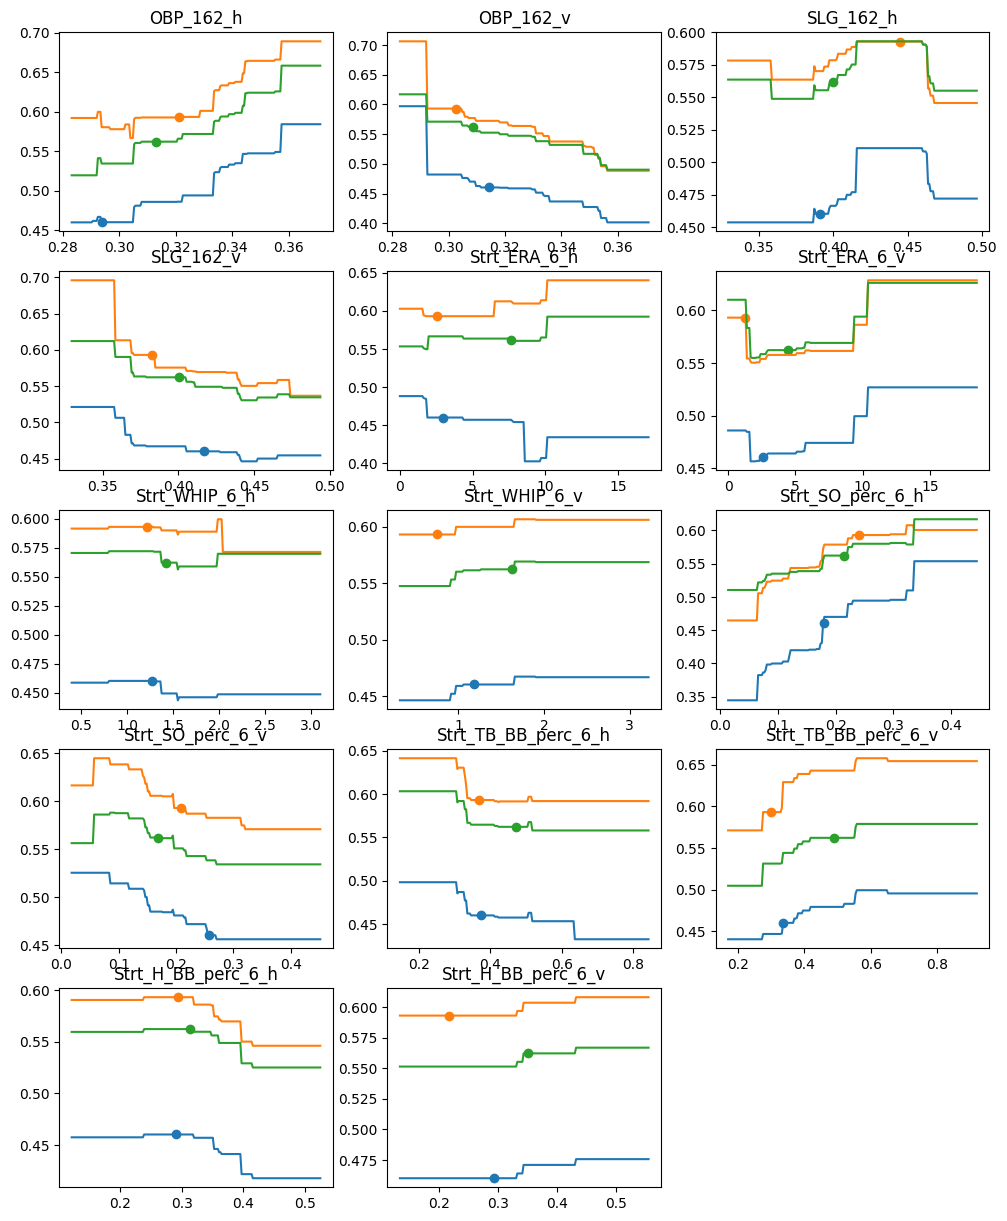

In [32]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

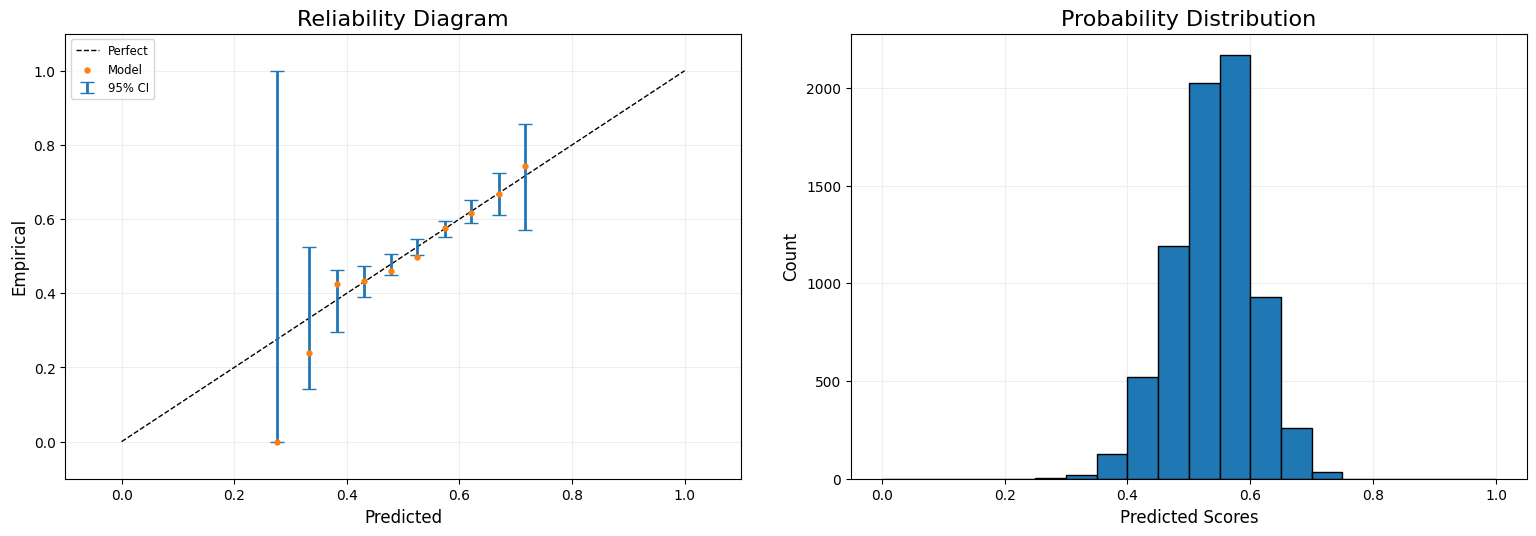

In [33]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [34]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [35]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept              0.165130
Strt_SO_perc_6_h       0.105844
Strt_SO_perc_6_v       0.081578
OBP_162_h              0.073836
OBP_162_v              0.071006
SLG_162_h              0.055592
SLG_162_v              0.035555
Strt_TB_BB_perc_6_v    0.028899
Strt_H_BB_perc_6_h     0.024550
Strt_WHIP_6_h          0.021274
Strt_TB_BB_perc_6_h    0.019625
Strt_ERA_6_v           0.015244
Strt_H_BB_perc_6_v     0.013971
Strt_WHIP_6_v          0.010854
Strt_ERA_6_h           0.005535
dtype: float64

In [36]:
## Let's add in the 34 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_34_h','Strt_ERA_34_v',
            'Strt_WHIP_34_h','Strt_WHIP_34_v',
            'Strt_SO_perc_34_h', 'Strt_SO_perc_34_v',
            'Strt_TB_BB_perc_34_h', 'Strt_TB_BB_perc_34_v',
            'Strt_ERA_6_h','Strt_ERA_6_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
]
target = 'home_victory'

In [37]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [38]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 20), (10615, 20), (7285, 20))

In [39]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689554
[20]	valid_0's binary_logloss: 0.688424
[30]	valid_0's binary_logloss: 0.687382
[40]	valid_0's binary_logloss: 0.686509
[50]	valid_0's binary_logloss: 0.685788
[60]	valid_0's binary_logloss: 0.685183
[70]	valid_0's binary_logloss: 0.684629
[80]	valid_0's binary_logloss: 0.684081
[90]	valid_0's binary_logloss: 0.683673
[100]	valid_0's binary_logloss: 0.683288
[110]	valid_0's binary_logloss: 0.682916
[120]	valid_0's binary_logloss: 0.682564
[130]	valid_0's binary_logloss: 0.682305
[140]	valid_0's binary_logloss: 0.682039
[150]	valid_0's binary_logloss: 0.681794
[160]	valid_0's binary_logloss: 0.681549
[170]	valid_0's binary_logloss: 0.681335
[180]	valid_0's binary_logloss: 0.681169
[190]	valid_0's binary_logloss: 0.681003
[200]	valid_0's binary_logloss: 0.680865
[210]	valid_0's binary_logloss: 0.680686
[220]	valid_0's binary_logloss: 0.680587
[230]	valid_0's binary_logloss: 0.680442
[240]

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [40]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [41]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6790470533152003, 0.6913722730242492)

In [42]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

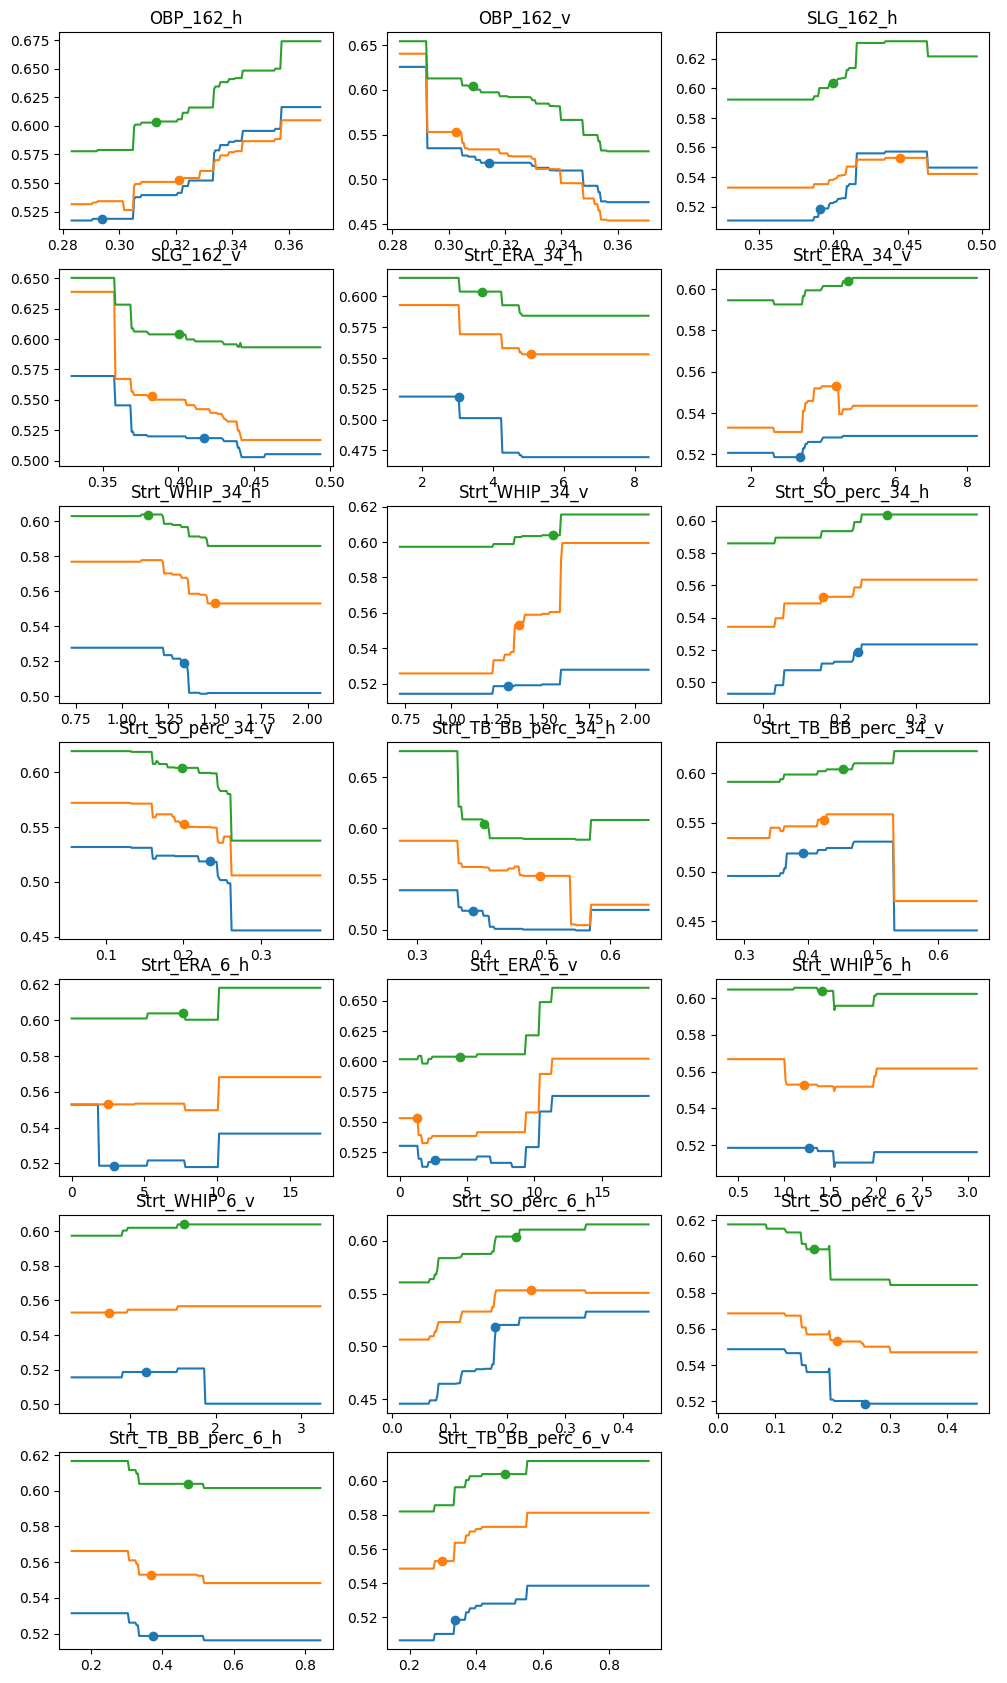

In [43]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

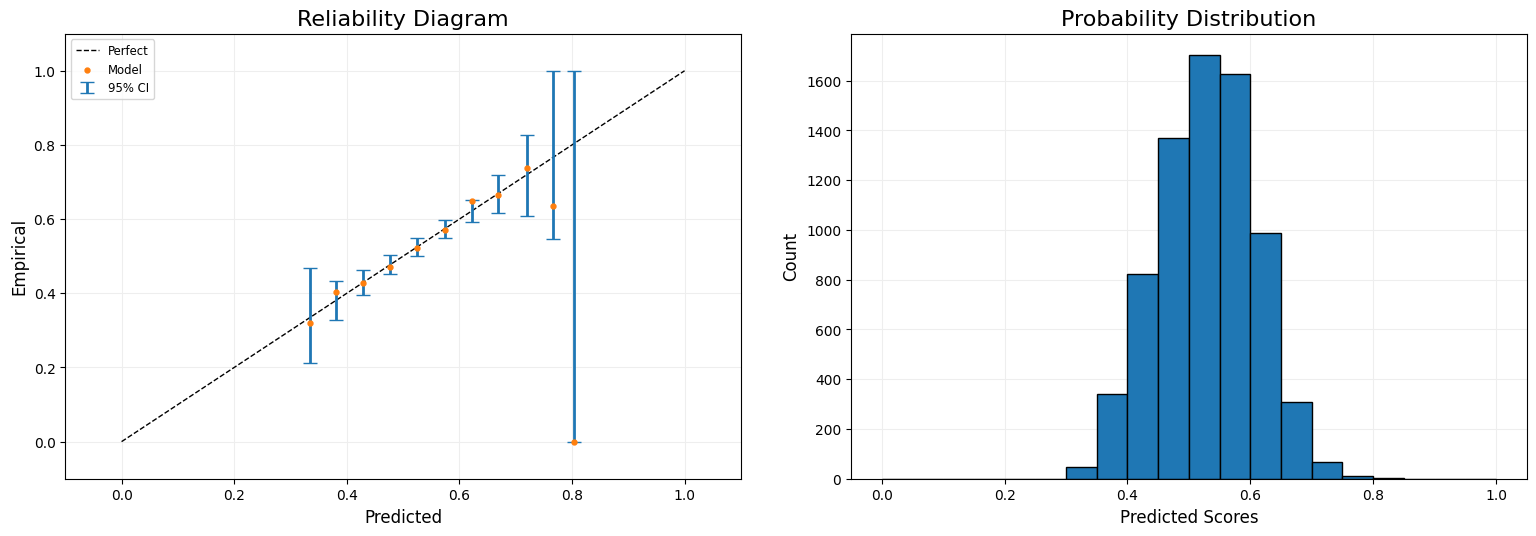

In [44]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [45]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [46]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.165610
Strt_SO_perc_34_v       0.077547
OBP_162_h               0.063698
OBP_162_v               0.061289
Strt_SO_perc_6_h        0.055834
SLG_162_h               0.050474
Strt_WHIP_34_v          0.047372
Strt_ERA_34_h           0.045687
Strt_WHIP_34_h          0.035994
Strt_TB_BB_perc_34_h    0.031740
SLG_162_v               0.030330
Strt_SO_perc_6_v        0.027850
Strt_SO_perc_34_h       0.024011
Strt_ERA_34_v           0.022298
Strt_TB_BB_perc_34_v    0.017194
Strt_TB_BB_perc_6_v     0.015480
Strt_WHIP_6_h           0.013774
Strt_TB_BB_perc_6_h     0.006784
Strt_ERA_6_v            0.006407
Strt_ERA_6_h            0.005200
Strt_WHIP_6_v           0.004845
dtype: float64

In [47]:
# Choose the best window size for each metric, drop ERA

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_34_h','Strt_WHIP_34_v',
            'Strt_TB_BB_perc_34_h', 'Strt_TB_BB_perc_34_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_34_v',
            
]
target = 'home_victory'

In [48]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [49]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 10), (10615, 10), (7285, 10))

In [50]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689637
[20]	valid_0's binary_logloss: 0.688572
[30]	valid_0's binary_logloss: 0.687514
[40]	valid_0's binary_logloss: 0.68669
[50]	valid_0's binary_logloss: 0.685979
[60]	valid_0's binary_logloss: 0.685329
[70]	valid_0's binary_logloss: 0.684771
[80]	valid_0's binary_logloss: 0.684204
[90]	valid_0's binary_logloss: 0.683767
[100]	valid_0's binary_logloss: 0.683416
[110]	valid_0's binary_logloss: 0.683037
[120]	valid_0's binary_logloss: 0.682735
[130]	valid_0's binary_logloss: 0.682459
[140]	valid_0's binary_logloss: 0.682221
[150]	valid_0's binary_logloss: 0.681972
[160]	valid_0's binary_logloss: 0.681749
[170]	valid_0's binary_logloss: 0.681553
[180]	valid_0's binary_logloss: 0.681359
[190]	valid_0's binary_logloss: 0.681222
[200]	valid_0's binary_logloss: 0.681079
[210]	valid_0's binary_logloss: 0.680943
[220]	valid_0's binary_logloss: 0.680781
[230]	valid_0's binary_logloss: 0.680692
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [51]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [52]:
# now about 5 bps worse than previous model...

log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.679189776008004, 0.6913722730242492)

In [53]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6704071693200951

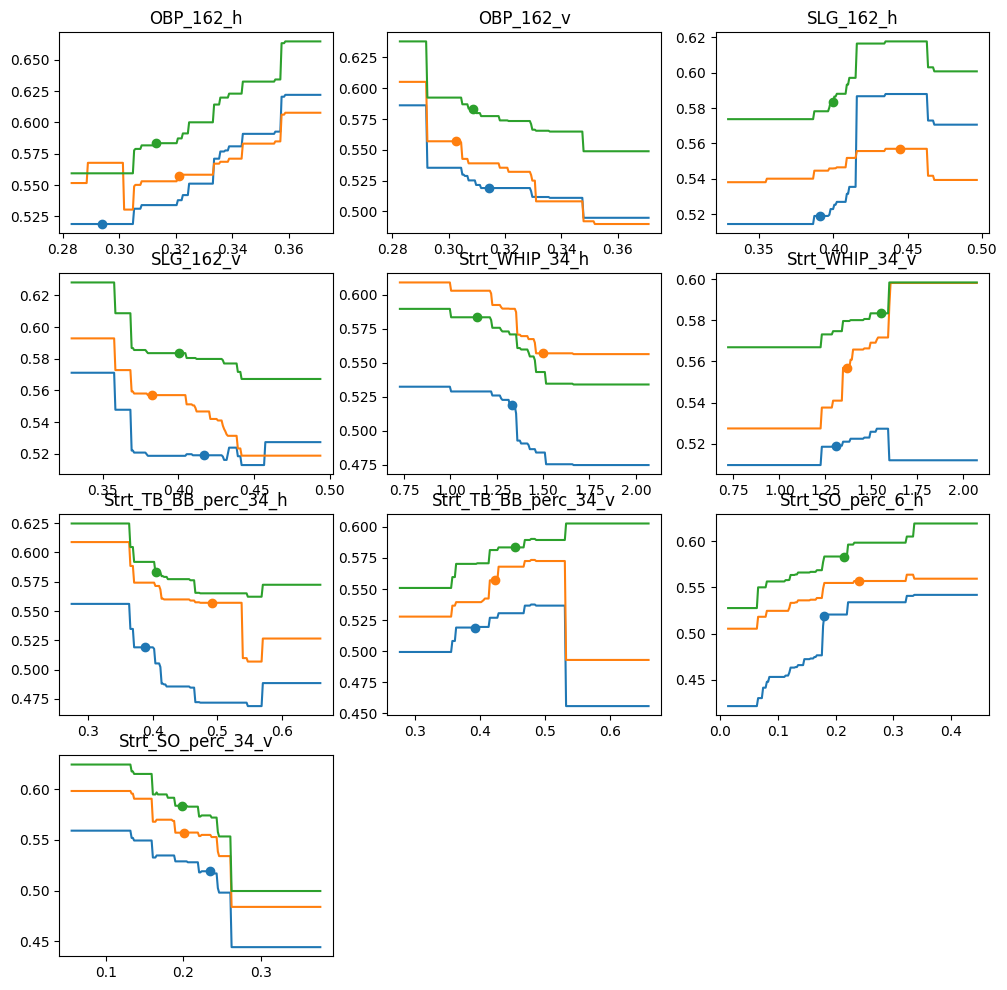

In [54]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

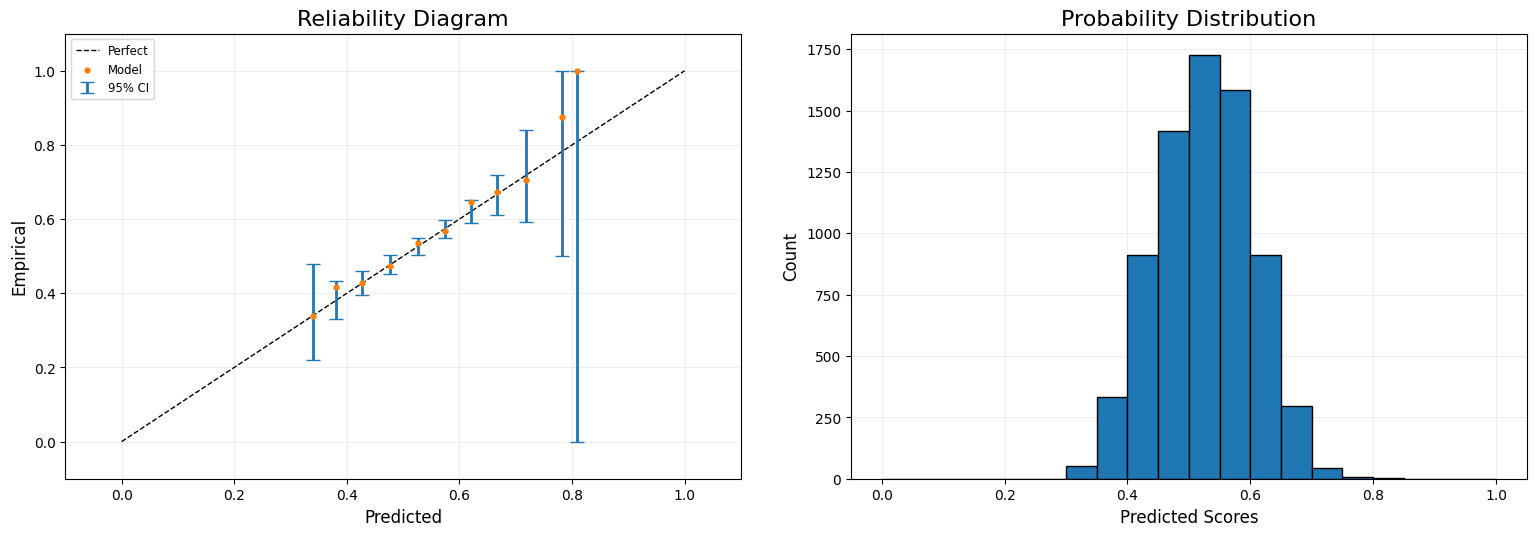

In [55]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [56]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [57]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.165617
Strt_SO_perc_34_v       0.106729
Strt_SO_perc_6_h        0.071989
Strt_WHIP_34_h          0.069030
OBP_162_h               0.062608
OBP_162_v               0.061256
Strt_WHIP_34_v          0.060253
SLG_162_h               0.054885
Strt_TB_BB_perc_34_h    0.048455
Strt_TB_BB_perc_34_v    0.035218
SLG_162_v               0.029022
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [58]:
# Simulate a test set (with given "true" probabilities) and compare two models, 

def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [59]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

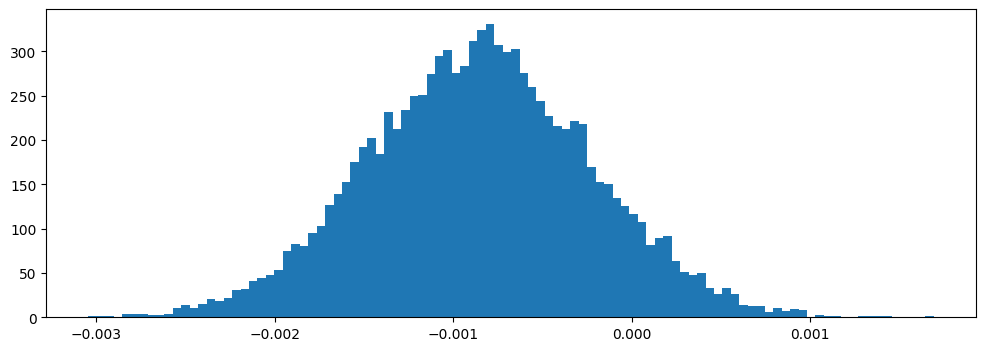

In [60]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

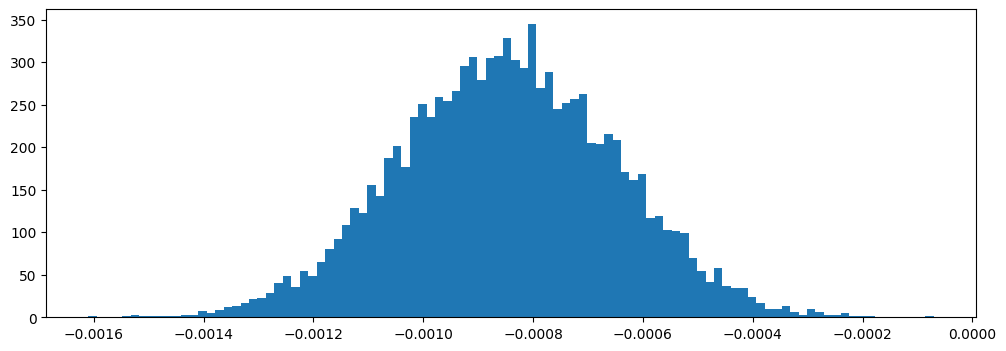

In [61]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [62]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

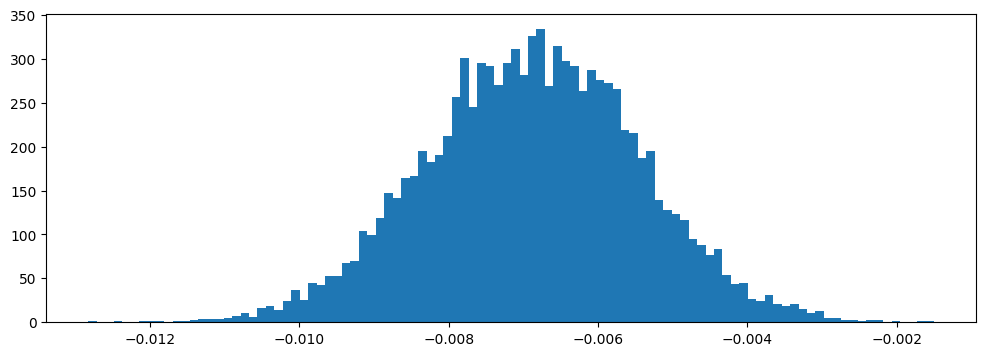

In [63]:
disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH